# Model Evaluation

In [2]:
import numpy as np
from utils import smoothing, load_data

## Load datasets and define feature names

In [3]:
train_path = '../data/train/tartagal0_train.csv'
val_path = '../data/val/tartagal0_val.csv'
col_names = ['Country NDVI lag 1', 'Country NDWI lag 1', 'Country LST day lag 3',  
             'Country LST night lag 1', 'Country TRMM lag 3', 'Country cold days 10', 
             'Country cold degrees 10']


n_cols, weeks, y, X = load_data(filename=train_path)
n_cols, weeks, y_val, X_val = load_data(filename=val_path)

In [4]:
# Rename feature names to avoid Country redundancy
col_names = ['NDVI lag 1', 'NDWI lag 1', 'LST day lag 3',  
             'LST night lag 1', 'TRMM lag 3', 'cold days 10', 
             'cold degrees 10']

## Load the respective dataframes

In [5]:
import pandas as pd

In [6]:
df_X = pd.DataFrame(X, columns=col_names)
df_y = pd.DataFrame(y, columns=['abundancy'])

In [7]:
df_X_val = pd.DataFrame(X_val, columns=col_names)
df_y_val = pd.DataFrame(y_val, columns=['abundancy'])

## Train and Validate the models

In [8]:
from utils import stats, print_stats

## **XGBoost**

In [9]:
from xgboost import XGBRegressor

/usr/local/lib/python3.6/dist-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
parameters = {
    'learning_rate': 0.01,
}
xgb_model = XGBRegressor(**parameters)

### **Cross Validation**

In [11]:
xgb_metrics = stats(df_X, df_y, xgb_model)

In [12]:
print_stats(*xgb_metrics)


Stats
-----

Model Scores:  [0.57235806 0.93820376 0.47880254 1.33071047 0.97076994]
Mean Score:  0.858168954367979
Standard Deviation of Score:  0.30593684822326955


## Plot fitted vs ground truth curves to compare

### First, only validation curves will be plot

In [13]:
xgb_model = XGBRegressor(**parameters)
xgb_model = xgb_model.fit(df_X, df_y)

In [14]:
val_predicted_y = xgb_model.predict(df_X_val)

In [15]:
val_df_y_shaped = df_y_val.abundancy

In [16]:
df_to_plot = pd.DataFrame(list(zip(val_predicted_y, val_df_y_shaped)), columns=['predicted', 'ground_truth'])

In /home/juansca/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/juansca/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/juansca/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/juansca/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/juansca/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


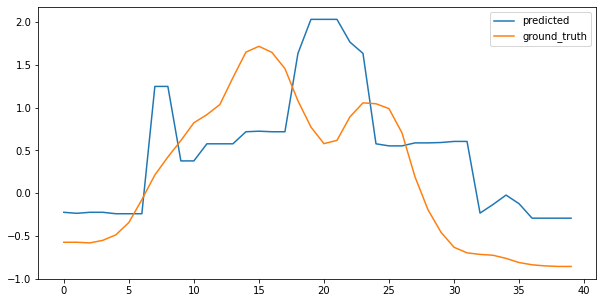

In [17]:
df_to_plot.plot(figsize=(10,5))

### Plot the same curve but using all the data

In [18]:
all_df_X = pd.concat([df_X, df_X_val])

In [19]:
all_predicted_y = xgb_model.predict(all_df_X)

In [20]:
all_true_y = pd.concat([df_y, df_y_val])
all_true_y_shaped = all_true_y.abundancy

In [21]:
df_to_plot = pd.DataFrame(list(zip(all_predicted_y, all_true_y_shaped)), columns=['predicted', 'ground_truth'])

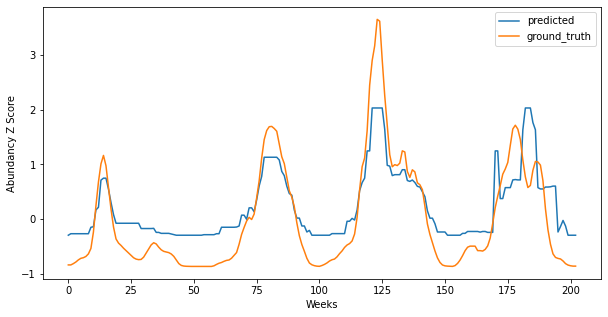

In [22]:
ax = df_to_plot.plot(figsize=(10,5))
ax.set_xlabel("Weeks")
ax.set_ylabel("Abundancy Z Score")
ax

In [140]:
fig = ax.get_figure()
fig.savefig('../modelo_vs_truth_xgboost.png')

## Compute some metrics 

In [23]:
from sklearn.metrics import mean_squared_error

### Compute MSE to the complete and validation (20%) datasets

In [24]:
validation_mse = mean_squared_error(val_df_y_shaped, val_predicted_y)
total_mse = mean_squared_error(all_true_y_shaped, all_predicted_y)

print('Validation MSE: ', validation_mse)
print('Total MSE: ', total_mse)

Validation MSE:  0.5565529337045103
Total MSE:  0.2968818605857616


### Compute Pearson Correlation between ground truth and predicted datapoints

#### For both datasets: complete and validation (20%)

In [25]:
from scipy.stats import pearsonr
val_corr = pearsonr(val_df_y_shaped, val_predicted_y)
total_corr = pearsonr(all_true_y_shaped, all_predicted_y)
print('Validation Corr: ', val_corr)
print('Total Corr: ', total_corr)

Validation Corr:  (0.632661572218705, 1.186535055984982e-05)
Total Corr:  (0.8982996890424272, 1.0172308721628836e-73)


# Use Shap information

## Removing the **BEST** features according _SHAP_ information

In [26]:
xgb_model = XGBRegressor(**parameters)
best_features = ['NDWI lag 1', 'LST night lag 1', 'LST day lag 3']

In [27]:
df_X_worst_features = df_X.drop(columns=best_features)
df_X_worst_features_val = df_X_val.drop(columns=best_features)

In [28]:
xgb_model = xgb_model.fit(df_X_worst_features, df_y)

In [29]:
val_worst_predicted_y = xgb_model.predict(df_X_worst_features_val)

### Plot fitted vs ground truth of all data

In [30]:
all_df_X_worst_features = pd.concat([df_X_worst_features, df_X_worst_features_val])

In [31]:
all_predicted_y_worst = xgb_model.predict(all_df_X_worst_features)

In [32]:
all_true_y = pd.concat([df_y, df_y_val])
all_true_y_shaped = all_true_y.abundancy

In [33]:
df_to_plot = pd.DataFrame(list(zip(all_predicted_y_worst, all_true_y_shaped)), columns=['predicted', 'ground_truth'])

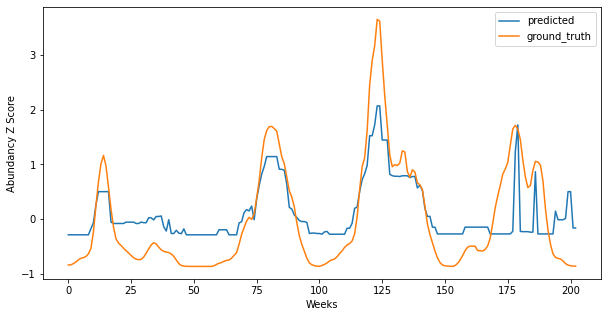

In [34]:
ax = df_to_plot.plot(figsize=(10,5))
ax.set_xlabel("Weeks")
ax.set_ylabel("Abundancy Z Score")
ax

### Compute MSE to the complete and validation (20%) datasets

In [35]:
validation_mse = mean_squared_error(val_df_y_shaped, val_worst_predicted_y)
total_mse = mean_squared_error(all_true_y_shaped, all_predicted_y_worst)

print('Validation MSE: ', validation_mse)
print('Total MSE: ', total_mse)

Validation MSE:  0.8369425579423864
Total MSE:  0.3795088006856396


## Removing the **WORST** features according _SHAP_ information

In [36]:
xgb_model = XGBRegressor(**parameters)
worst_features = ['cold days 10', 'TRMM lag 3', 'cold degrees 10']

In [37]:
df_X_best_features = df_X.drop(columns=worst_features)
df_X_best_features_val = df_X_val.drop(columns=worst_features)

In [38]:
xgb_model = xgb_model.fit(df_X_best_features, df_y)

In [39]:
val_best_predicted_y = xgb_model.predict(df_X_best_features_val)

### Plot fitted vs ground truth of all data

In [40]:
all_df_X_best_features = pd.concat([df_X_best_features, df_X_best_features_val])

In [41]:
all_predicted_y_best = xgb_model.predict(all_df_X_best_features)

In [42]:
all_true_y = pd.concat([df_y, df_y_val])
all_true_y_shaped = all_true_y.abundancy

In [43]:
df_to_plot = pd.DataFrame(list(zip(all_predicted_y_best, all_true_y_shaped)), columns=['predicted', 'ground_truth'])

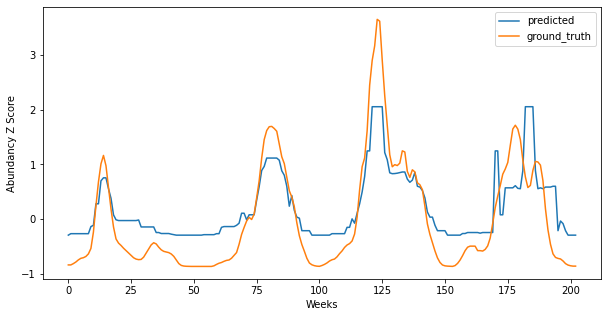

In [44]:
ax = df_to_plot.plot(figsize=(10,5))
ax.set_xlabel("Weeks")
ax.set_ylabel("Abundancy Z Score")
ax

### Compute MSE to the complete and validation (20%) datasets

In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
validation_mse = mean_squared_error(val_df_y_shaped, val_best_predicted_y)
total_mse = mean_squared_error(all_true_y_shaped, all_predicted_y_best)

print('Validation MSE: ', validation_mse)
print('Total MSE: ', total_mse)

Validation MSE:  0.6010711766033107
Total MSE:  0.3119903571551427
